In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from subprocess import check_output
import base64
import urllib.parse

In [2]:
from pathlib import Path
import re

In [3]:
cols_keep = [
    "id",
    "last_scraped",
    "neighbourhood_group_cleansed",
    "neighbourhood_cleansed",
    "latitude",
    "longitude",
    "room_type",
    "property_type",
    "accommodates",
    "bedrooms",
    "bathrooms_text",
    "price",
    "minimum_nights",
    "availability_365",
    "number_of_reviews"
]

In [4]:
#Preparar datos idealista

BASE_PATH = "Datos_Naza/"

df_idealista_alquiler = pd.read_excel(
    BASE_PATH + "idealista_alquiler_m2.xlsx"
)

df_idealista_venta = pd.read_excel(
    BASE_PATH + "idealista_venta_m2.xlsx"
)

In [5]:
#Preparar datos Airbnb

df_airbnb_09 = pd.read_csv("Datos_Naza/Airbnb_2025/listings_2025_09_14.csv.gz", usecols=cols_keep,low_memory=False)

In [6]:
#Airbnb
df_airbnb = df_airbnb_09.copy()

In [7]:
#Precio - numérico

df_airbnb["price"] = (
    df_airbnb["price"]
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

In [ ]:
#Fechas
df_airbnb["last_scraped"] = pd.to_datetime(df_airbnb["last_scraped"])

In [9]:
df_airbnb = df_airbnb.rename(columns={
    "neighbourhood_group_cleansed": "distrito",
    "neighbourhood_cleansed": "barrio"
})

In [11]:
#Renombramos para que sea más claro
df_airbnb[["distrito", "barrio", "price"]].head()

,distrito,barrio,price
0,Latina,Cármenes,NaN
1,Centro,Sol,157.0
2,Centro,Embajadores,NaN
3,Centro,Universidad,143.0
4,Centro,Justicia,65.0


In [12]:
#Volumen de anuncios por distrito
airbnb_distrito = (
    df_airbnb
    .groupby("distrito")
    .size()
    .reset_index(name="num_anuncios")
    .sort_values("num_anuncios", ascending=False)
)

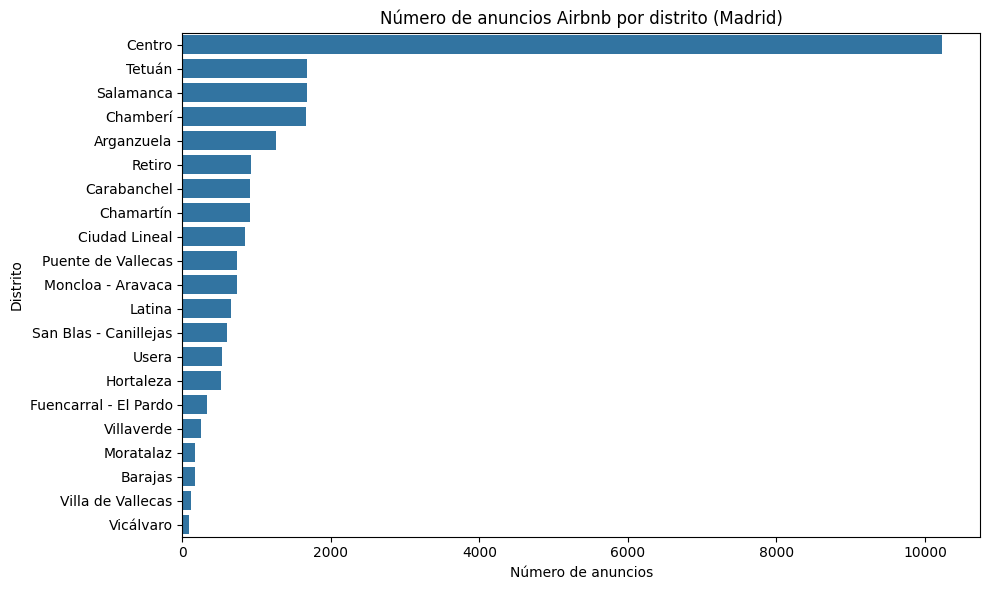

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=airbnb_distrito,
    y="distrito",
    x="num_anuncios"
)
plt.title("Número de anuncios Airbnb por distrito (Madrid)")
plt.xlabel("Número de anuncios")
plt.ylabel("Distrito")
plt.tight_layout()
plt.show()

In [14]:
#Análisis por barrio
airbnb_barrio = (
    df_airbnb
    .groupby(["distrito", "barrio"])
    .size()
    .reset_index(name="num_anuncios")
    .sort_values("num_anuncios", ascending=False)
)

In [16]:
top_barrios_airbnb = airbnb_barrio.head(15)

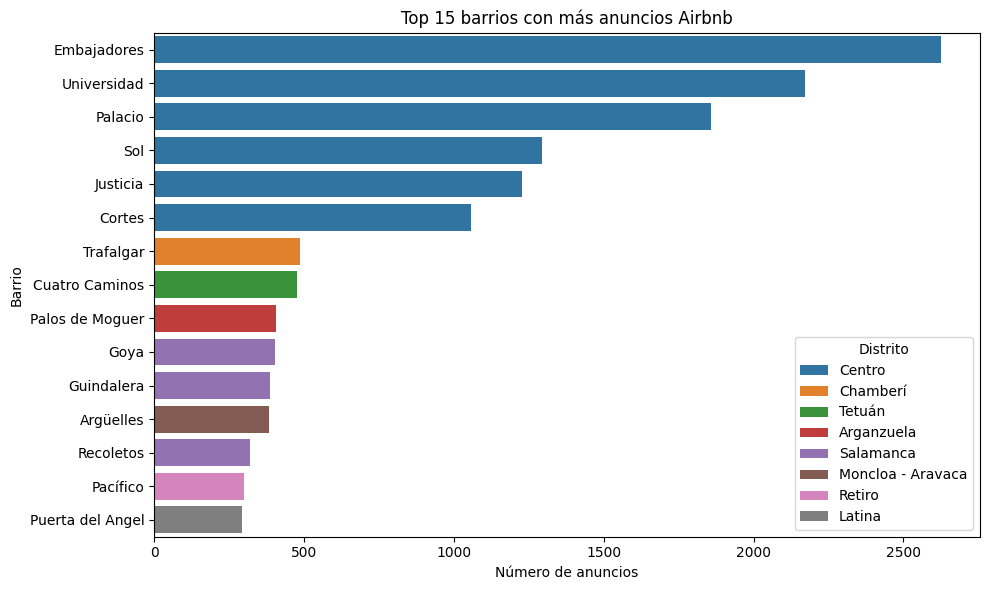

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_barrios_airbnb,
    y="barrio",
    x="num_anuncios",
    hue="distrito",
    dodge=False
)
plt.title("Top 15 barrios con más anuncios Airbnb")
plt.xlabel("Número de anuncios")
plt.ylabel("Barrio")
plt.legend(title="Distrito")
plt.tight_layout()
plt.show()

In [18]:
#Precio por barrio (los más relevantes)
precio_airbnb_barrio = (
    df_airbnb
    .groupby(["distrito", "barrio"])["price"]
    .mean()
    .reset_index(name="precio_medio_noche")
)

In [19]:
precio_top_barrios = precio_airbnb_barrio.merge(
    top_barrios_airbnb,
    on=["distrito", "barrio"]
)

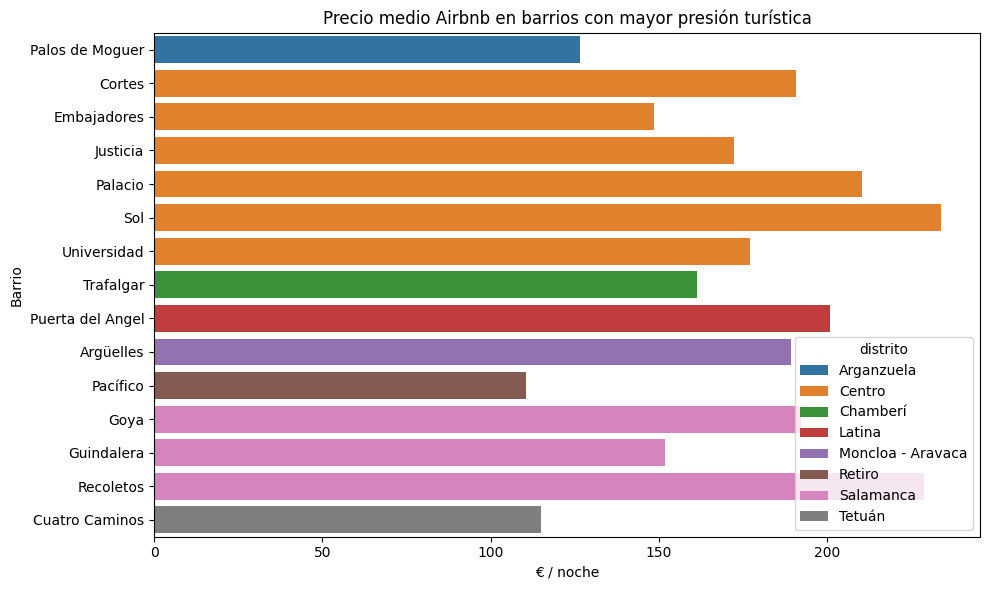

In [20]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=precio_top_barrios,
    y="barrio",
    x="precio_medio_noche",
    hue="distrito",
    dodge=False
)
plt.title("Precio medio Airbnb en barrios con mayor presión turística")
plt.xlabel("€ / noche")
plt.ylabel("Barrio")
plt.tight_layout()
plt.show()

In [21]:
#Idealista
def limpiar_precio_m2(col):
    return (
        col.str.replace("€/m2", "", regex=False)
           .str.replace("€", "", regex=False)
           .str.replace(".", "", regex=False)
           .str.replace(",", ".", regex=False)
           .astype(float)
    )

In [22]:
df_idealista_venta["precio_m2"] = limpiar_precio_m2(df_idealista_venta["Precio m2 nov 2025"])
df_idealista_alquiler["precio_m2"] = limpiar_precio_m2(df_idealista_alquiler["Precio m2 nov 2025"])

In [23]:
#Precio m2 por distrito
precio_venta_distrito = (
    df_idealista_venta
    .groupby("Distrito")["precio_m2"]
    .mean()
    .reset_index()
    .sort_values("precio_m2", ascending=False)
)

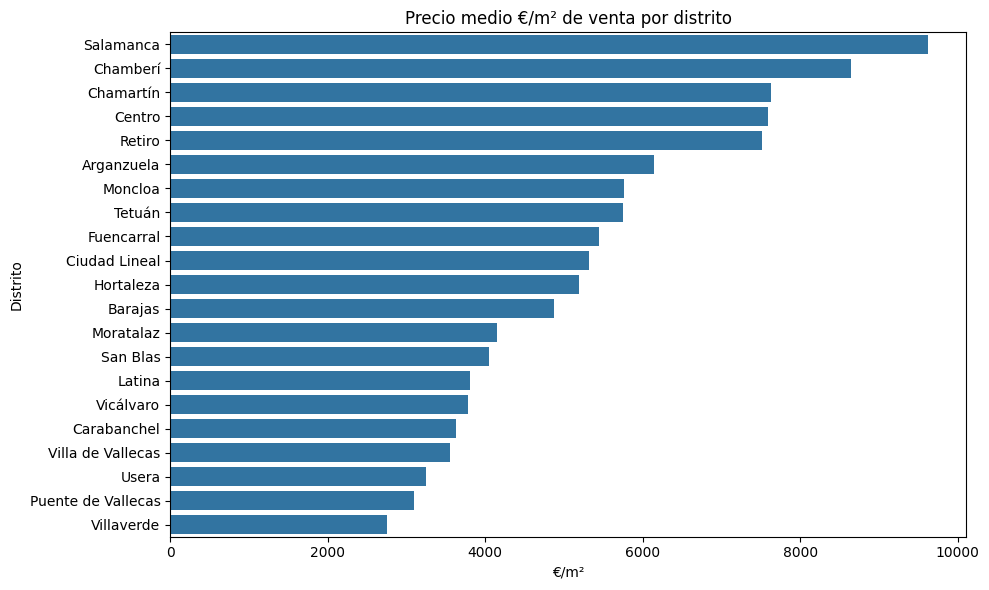

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=precio_venta_distrito,
    y="Distrito",
    x="precio_m2"
)
plt.title("Precio medio €/m² de venta por distrito")
plt.xlabel("€/m²")
plt.ylabel("Distrito")
plt.tight_layout()
plt.show()

In [25]:
#Análisis por barrio

precio_venta_barrio = (
    df_idealista_venta
    .groupby(["Distrito", "Barrio"])["precio_m2"]
    .mean()
    .reset_index()
    .sort_values("precio_m2", ascending=False)
)

In [26]:
top_barrios_venta = precio_venta_barrio.head(15)

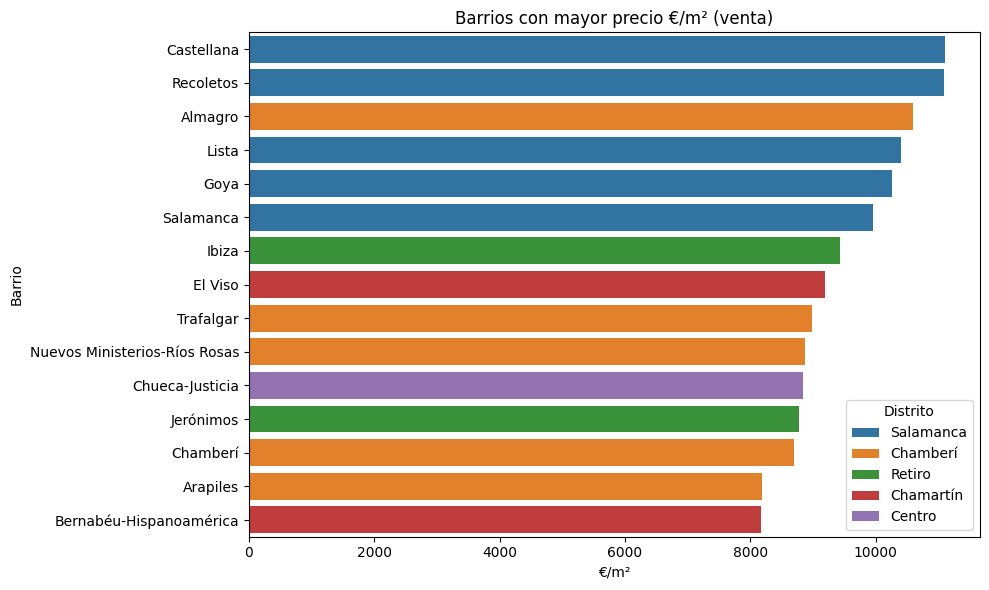

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_barrios_venta,
    y="Barrio",
    x="precio_m2",
    hue="Distrito",
    dodge=False
)
plt.title("Barrios con mayor precio €/m² (venta)")
plt.xlabel("€/m²")
plt.ylabel("Barrio")
plt.tight_layout()
plt.show()

El análisis por separado de Airbnb e Idealista muestra que los distritos y barrios con mayor concentración de alquiler turístico coinciden con aquellos que presentan precios €/m² más elevados, especialmente en zonas centrales de Madrid. Aunque aún no se ha realizado un cruce directo entre fuentes, el patrón espacial es consistente.

In [30]:
def cargar_airbnb(path, mes):
    df = pd.read_csv(path, usecols=cols_keep, low_memory=False)
    df["mes"] = mes
    
    # Precio a numérico
    df["price"] = (
        df["price"]
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .astype(float)
    )
    
    # Normalizar distrito y barrio
    df["distrito"] = (
        df["neighbourhood_group_cleansed"]
        .str.lower()
        .str.strip()
    )
    
    df["barrio"] = (
        df["neighbourhood_cleansed"]
        .str.lower()
        .str.strip()
    )
    
    return df

In [32]:
df_mar = cargar_airbnb("Datos_Naza/Airbnb_2025/listings_2025_03_05.csv.gz", "marzo")
df_jun = cargar_airbnb("Datos_Naza/Airbnb_2025/listings_2025_06_12.csv.gz", "junio")
df_sep = cargar_airbnb("Datos_Naza/Airbnb_2025/listings_2025_09_14.csv.gz", "septiembre")

df_airbnb = pd.concat([df_mar, df_jun, df_sep], ignore_index=True)

In [33]:
#Nº de anuncios por mes
anuncios_mes = df_airbnb.groupby("mes")["id"].nunique().reset_index()

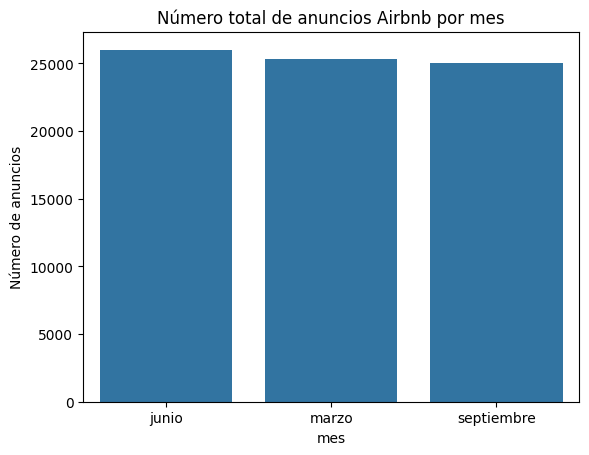

In [34]:
sns.barplot(data=anuncios_mes, x="mes", y="id")
plt.title("Número total de anuncios Airbnb por mes")
plt.ylabel("Número de anuncios")
plt.show()

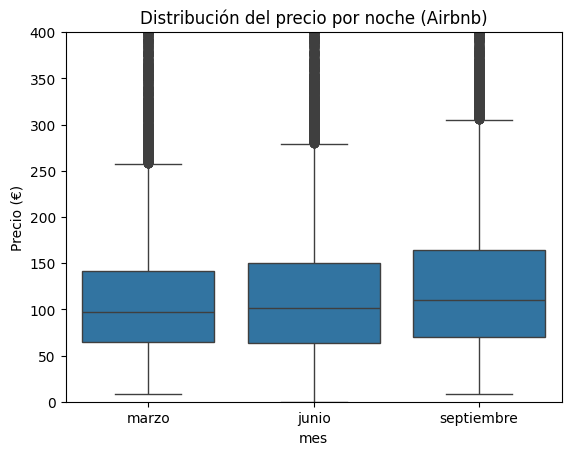

In [35]:
#Distribución precios por mes
sns.boxplot(data=df_airbnb, x="mes", y="price")
plt.ylim(0, 400)
plt.title("Distribución del precio por noche (Airbnb)")
plt.ylabel("Precio (€)")
plt.show()

In [36]:
#Anuncios por distrito y mes
airbnb_distrito_mes = (
    df_airbnb
    .groupby(["mes", "distrito"])
    .agg(
        num_anuncios=("id", "nunique"),
        precio_medio=("price", "mean")
    )
    .reset_index()
)

In [37]:
#Distritos más densos 
top_distritos = (
    airbnb_distrito_mes
    .groupby("distrito")["num_anuncios"]
    .mean()
    .sort_values(ascending=False)
    .head(6)
    .index
)

df_top = airbnb_distrito_mes[
    airbnb_distrito_mes["distrito"].isin(top_distritos)
]

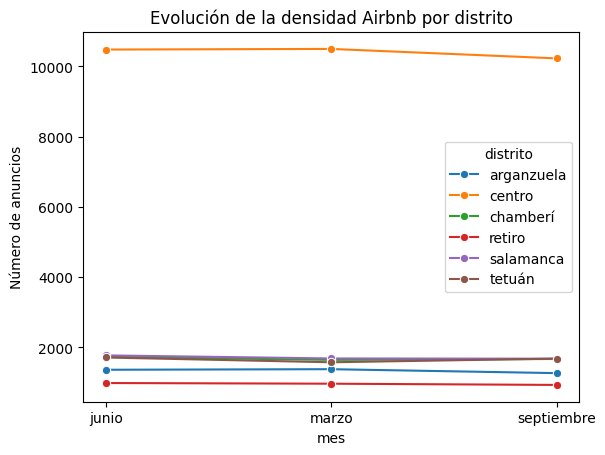

In [38]:
sns.lineplot(
    data=df_top,
    x="mes",
    y="num_anuncios",
    hue="distrito",
    marker="o"
)
plt.title("Evolución de la densidad Airbnb por distrito")
plt.ylabel("Número de anuncios")
plt.show()

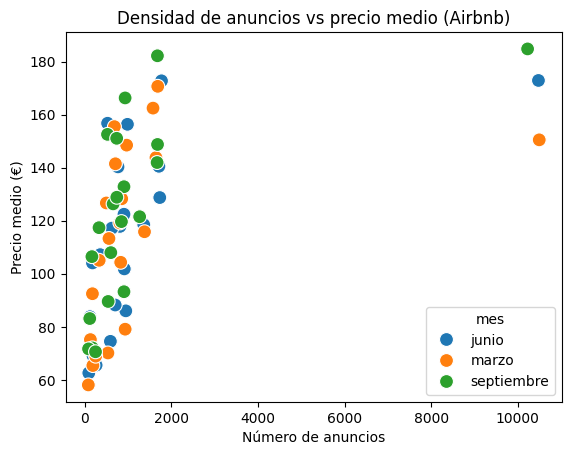

In [ ]:
#Densidad por precio
sns.scatterplot(
    data=airbnb_distrito_mes,
    x="num_anuncios",
    y="precio_medio",
    hue="mes",
    s=100
)
plt.title("Densidad de anuncios vs precio medio (Airbnb)")
plt.xlabel("Número de anuncios")
plt.ylabel("Precio medio (€)")
plt.show()

In [40]:
#Top barrios trimestral por densidad
airbnb_barrio = (
    df_airbnb
    .groupby(["barrio"])
    .agg(
        num_anuncios=("id", "nunique"),
        precio_medio=("price", "mean")
    )
    .reset_index()
)

top_barrios = airbnb_barrio.sort_values(
    "num_anuncios", ascending=False
).head(10)

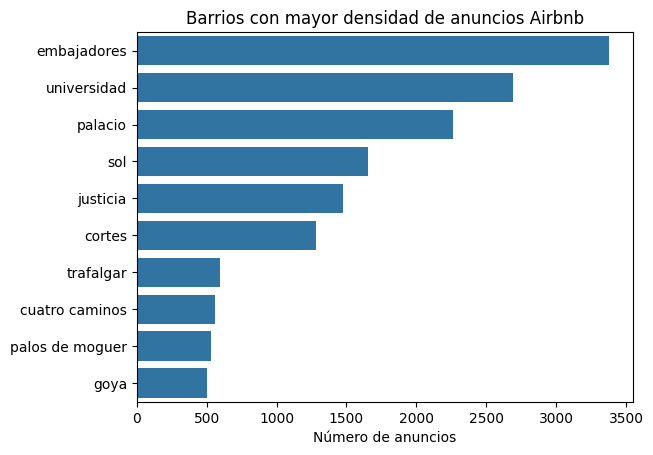

In [41]:
sns.barplot(
    data=top_barrios,
    y="barrio",
    x="num_anuncios"
)
plt.title("Barrios con mayor densidad de anuncios Airbnb")
plt.xlabel("Número de anuncios")
plt.ylabel("")
plt.show()

El análisis temporal de Airbnb para marzo, junio y septiembre de 2025 muestra que la concentración de anuncios no es estacional, sino estructural. Los mismos distritos y barrios concentran la mayor densidad de viviendas turísticas.